<center><h1>Merchandise Popularity Prediction</h1></center>

<center><h2>Overview</h2><center>

Big Brands spend a significant amount on popularizing a product. Nevertheless, their efforts go in vain while establishing the merchandise in the hyperlocal market. Based on different geographical conditions same attributes can communicate a piece of much different information about the customer. Hence, insights this is a must for any brand owner.

In this competition, we have brought the data gathered from one of the top apparel brands in India. Provided the details concerning category, score, and presence in the store, participants are challenged to predict the popularity level of the merchandise.

The popularity class decides how popular the product is given the attributes which a store owner can control to make it happen.

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from tqdm.auto import tqdm

import datetime

from IPython.display import Image, display

from sklearnex import patch_sklearn

patch_sklearn()

from sklearn.utils.validation import check_is_fitted

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.utils import compute_class_weight

from sklearn import metrics

from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    GridSearchCV,
    cross_validate,
    cross_val_score,
    cross_val_predict,
)

from sklearn.feature_selection import (
    VarianceThreshold,
    f_classif,
    SelectKBest,
    SelectFromModel,
    RFE,
)

from imblearn import over_sampling, under_sampling, ensemble
from imblearn.metrics import (
    sensitivity_specificity_support,
    classification_report_imbalanced,
)

from skopt import BayesSearchCV, gp_minimize, space
from skopt.utils import use_named_args

# import optuna

from joblib import dump, load

from prettytable import PrettyTable

from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

sns.set(rc={"figure.figsize": (10, 8)}, font_scale=1.25)
plt.style.use("dark_background")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [34]:
np.random.seed(42)

<center><h2>Exploratory Data Analysis</h2><center>

### About Dataset

- **Train.csv** - `18208 x 12` (Includes popularity Column as Target variable)
- **Test.csv** - `12140 x 11` 

In [35]:
train_df = pd.read_csv("./MPP_Dataset/Train.csv")
test_df = pd.read_csv("./MPP_Dataset/Test.csv")

In [36]:
train_df.head()

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time,popularity
0,0.407,0.00380,2,-35.865,1,0.9920,0.944,0.0988,0.1100,113.911,189125,4
1,0.234,0.10500,0,-19.884,1,0.9440,0.900,0.1290,0.0382,76.332,186513,4
2,0.668,0.72600,9,-7.512,1,0.0387,0.000,0.1340,0.4530,124.075,172143,4
3,0.184,0.00561,4,-34.357,1,0.8490,0.931,0.1110,0.0641,79.037,184000,5
4,0.231,0.13100,6,-22.842,1,0.9370,0.000,0.1090,0.0677,109.560,186507,3


In [37]:
test_df.head()

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time
0,0.164,0.994,1,-23.718,0,0.12400,0.99100,0.7890,0.00001,127.602,236436
1,0.586,0.636,4,-7.710,1,0.00208,0.32200,0.1070,0.35500,136.337,253631
2,0.457,0.743,0,-7.591,1,0.40400,0.00931,0.2010,0.68800,154.902,215669
3,0.423,0.748,5,-9.832,1,0.03000,0.22100,0.1690,0.42800,93.977,325200
4,0.802,0.756,2,-10.791,0,0.08430,0.00765,0.0521,0.96300,131.715,288293


### Attributes in the dataset

In [38]:
train_df.columns.to_list()

['Store_Ratio',
 'Basket_Ratio',
 'Category_1',
 'Store_Score',
 'Category_2',
 'Store_Presence',
 'Score_1',
 'Score_2',
 'Score_3',
 'Score_4',
 'time',
 'popularity']

There are a total of 11 features, and the last column `popularity` is the target column. Let's have a look at it.

In [39]:
train_df.popularity.unique().tolist()

[4, 5, 3, 1, 0]

`popularity` column has 5 unique popularity values. This is a problem of multi-class classification. 

### Dataframe info

In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Store_Ratio     18208 non-null  float64
 1   Basket_Ratio    18208 non-null  float64
 2   Category_1      18208 non-null  int64  
 3   Store_Score     18208 non-null  float64
 4   Category_2      18208 non-null  int64  
 5   Store_Presence  18208 non-null  float64
 6   Score_1         18208 non-null  float64
 7   Score_2         18208 non-null  float64
 8   Score_3         18208 non-null  float64
 9   Score_4         18208 non-null  float64
 10  time            18208 non-null  int64  
 11  popularity      18208 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.7 MB


In [41]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12140 entries, 0 to 12139
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Store_Ratio     12140 non-null  float64
 1   Basket_Ratio    12140 non-null  float64
 2   Category_1      12140 non-null  int64  
 3   Store_Score     12140 non-null  float64
 4   Category_2      12140 non-null  int64  
 5   Store_Presence  12140 non-null  float64
 6   Score_1         12140 non-null  float64
 7   Score_2         12140 non-null  float64
 8   Score_3         12140 non-null  float64
 9   Score_4         12140 non-null  float64
 10  time            12140 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 1.0 MB


### Of Null values and missing values

In [42]:
train_df.isna().sum()

Store_Ratio       0
Basket_Ratio      0
Category_1        0
Store_Score       0
Category_2        0
Store_Presence    0
Score_1           0
Score_2           0
Score_3           0
Score_4           0
time              0
popularity        0
dtype: int64

*Obvservation*

- No null or missing values in train dataset

In [43]:
test_df.isna().sum()

Store_Ratio       0
Basket_Ratio      0
Category_1        0
Store_Score       0
Category_2        0
Store_Presence    0
Score_1           0
Score_2           0
Score_3           0
Score_4           0
time              0
dtype: int64

*Obvservation*
- No null or missing values in test dataset 

### Basic Statistics at glance 

In [44]:
train_df.describe()

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time,popularity
count,18208.000000,18208.000000,18208.000000,18208.000000,18208.000000,18208.000000,18208.000000,18208.000000,18208.000000,18208.000000,1.820800e+04,18208.000000
mean,0.544283,0.483585,5.155536,-12.198086,0.648506,0.477702,0.322109,0.164888,0.421440,115.305776,2.180101e+05,3.850231
std,0.202709,0.302010,3.535068,8.370566,0.477450,0.380634,0.413493,0.136531,0.271922,31.478303,9.648289e+04,0.544226
min,0.000000,0.000216,0.000000,-47.576000,0.000000,0.000000,0.000000,0.011900,0.000000,0.000000,3.184400e+04,0.000000
25%,0.411000,0.200000,2.000000,-16.496250,0.000000,0.086175,0.000001,0.095300,0.184750,90.974250,1.696202e+05,4.000000
50%,0.573000,0.517000,5.000000,-9.166500,1.000000,0.430000,0.002245,0.112000,0.393000,114.022500,2.046460e+05,4.000000
75%,0.699000,0.742000,8.000000,-5.943750,1.000000,0.895000,0.859000,0.176000,0.640000,134.997000,2.471562e+05,4.000000
max,0.998000,1.000000,11.000000,-0.079000,1.000000,0.996000,1.000000,0.991000,0.999000,219.701000,3.908467e+06,5.000000


In [45]:
test_df.describe()

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time
count,12140.000000,12140.000000,12140.000000,12140.000000,12140.000000,12140.000000,12140.000000,12140.000000,12140.000000,12140.000000,1.214000e+04
mean,0.543776,0.488879,5.121417,-12.062847,0.642916,0.474675,0.321641,0.165942,0.420485,115.748041,2.154031e+05
std,0.200109,0.301217,3.528765,8.300385,0.479160,0.377582,0.414438,0.139109,0.270508,31.519999,8.231108e+04
min,0.000000,0.000000,0.000000,-46.847000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.406700e+04
25%,0.414750,0.213000,2.000000,-16.066000,0.000000,0.087775,0.000001,0.095900,0.190000,90.908750,1.700000e+05
50%,0.570000,0.521000,5.000000,-9.046500,1.000000,0.430500,0.002050,0.112000,0.392000,114.618500,2.043415e+05
75%,0.696000,0.745000,8.000000,-5.891750,1.000000,0.882000,0.861000,0.173250,0.633000,135.829250,2.445222e+05
max,0.978000,1.000000,11.000000,0.662000,1.000000,0.996000,1.000000,0.994000,1.000000,219.701000,1.782178e+06


Let's begin with some basic EDA

### Count of popularity values (our target)

In [46]:
train_df.popularity.value_counts().sort_values()

0       16
1      323
5      472
3     2166
4    15231
Name: popularity, dtype: int64

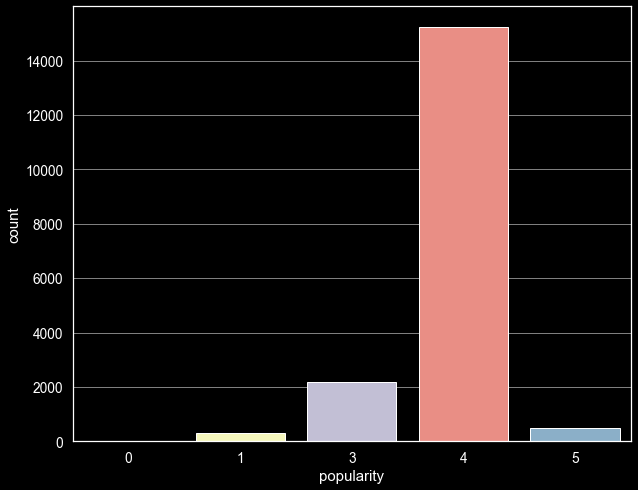

In [47]:
_ = sns.countplot(data=train_df, x='popularity')

*Observation*

- Highly imbalanced dataset
- Minority class - `0` with only 16 values
- Majority class - `4` with 15231 values

### Univariate analysis

Small utility function which will help us to plot our feature distributions

In [48]:
def plot_all_feats(df=None, typ="hist", title="Features and their distributions"):
    """
    This function can be used to plot all the features in the
    dataset as subplots with a specific type of plot.

    Currently supported plots : {'hist', 'bar', 'kde', 'box'}

    Parameters
    ----------
    df: pd.Dataframe
        The dataframe

    typ: str {'hist', 'bar', 'kde', 'box'}
        The type of plot to be used

    title: str
        Title of the complete Figure.
    """
    
    types = {
        "hist": sns.histplot,
        "bar": sns.barplot,
        "kde": sns.kdeplot,
        "box": sns.boxplot,
        "violin": sns.violinplot,
        "boxen": sns.boxenplot, 
    }

    if typ not in types:
        print(f"[Error] Plot is not defined, choose from {list(types.keys())}")
    else:

        fig, axes = plt.subplots(4, 3)
        fig.suptitle(title)
        fig.set_size_inches(15, 15, forward=True)
        fig.subplots_adjust(hspace=0.5)
        
        FEATURE_COLUMNS = df.columns.to_list()
    
        k = 0
        for i in range(4):
            for j in range(3):
                types[typ](ax=axes[i, j], data=df, x=FEATURE_COLUMNS[k]).set(ylabel=None)
                k += 1
                

#### Histogram for features

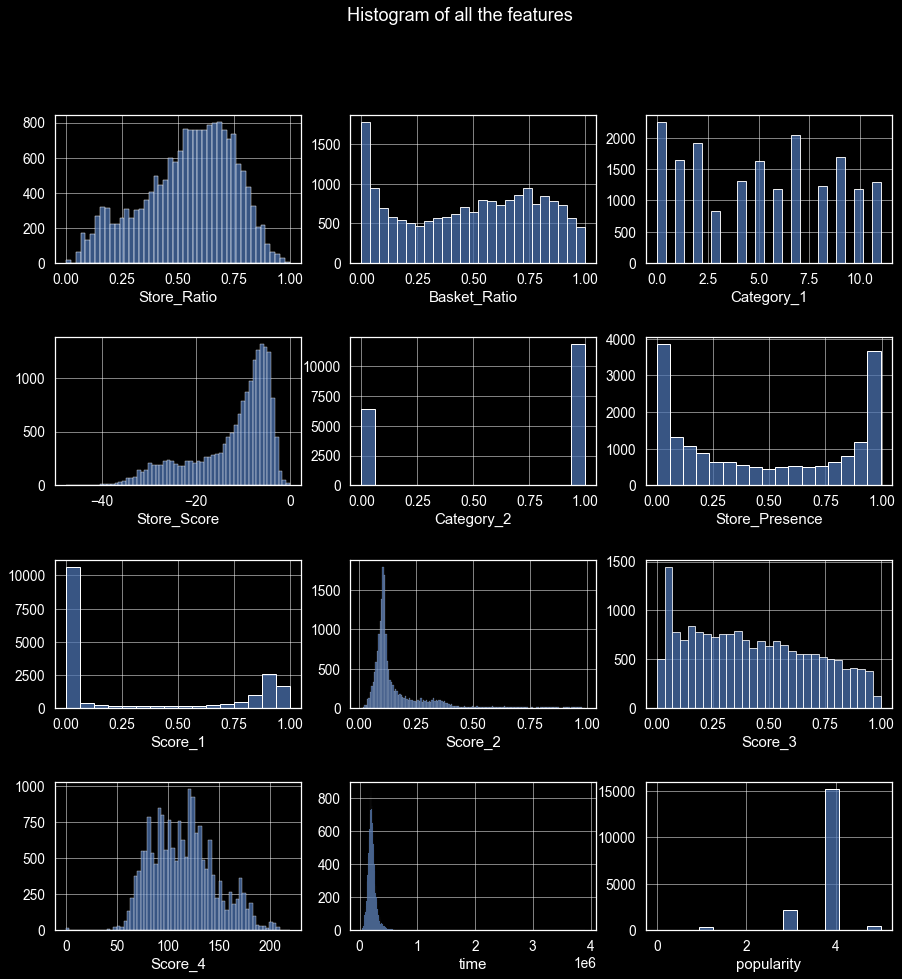

In [49]:
plot_all_feats(df=train_df, typ='hist', title='Histogram of all the features')

#### KDE plots for all features

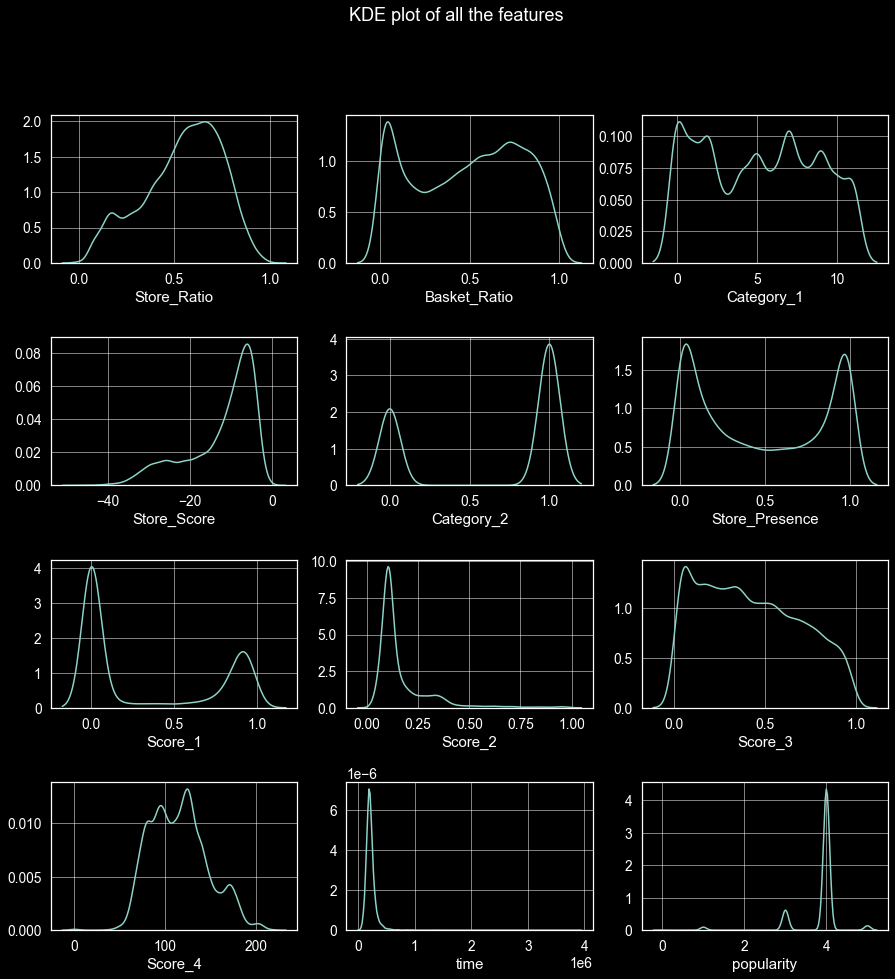

In [50]:
plot_all_feats(df=train_df, typ='kde', title="KDE plot of all the features")

*Obvservation*
- We can see that `Store_Presence` has a bimodal distribution
- `Score_2` & `time` are left skewed
- `Store_Score` is right skewed
- `Category_2` has only two kinds of values 1 or 0 (kind of like an encoded categorical variable)
- `Category_1` also has discreet values (we will look at them individually)
- `Store_Ratio`, `Basket_Ratio`, `Score_1`, `Score_2`, `Score_3` all of them have values ranging from 0 to 1

Checking out unique values in **`Category_1`**

In [51]:
train_df.Category_1.unique()

array([ 2,  0,  9,  4,  6,  3, 10,  5,  8,  1,  7, 11], dtype=int64)

`Category_1` has 12 unique values

#### Boxplots for all features

****************************************
From BOX-PLOT we can infer the following
****************************************


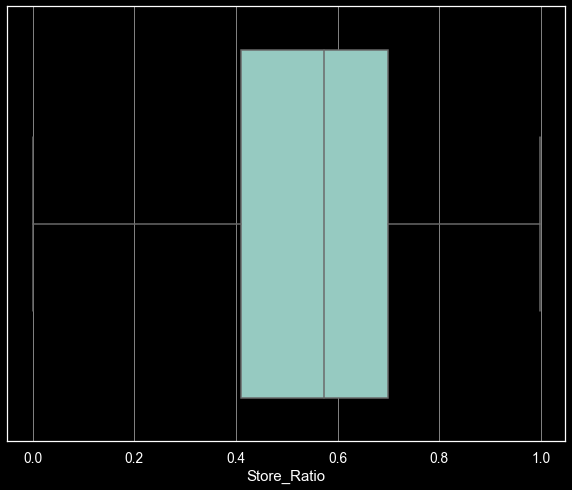

Column: Store_Ratio
--------------------
Mean => 0.544
25% values are less than => 0.411
75% values are less than => 0.699
Inter-Quartile-Range => 0.288


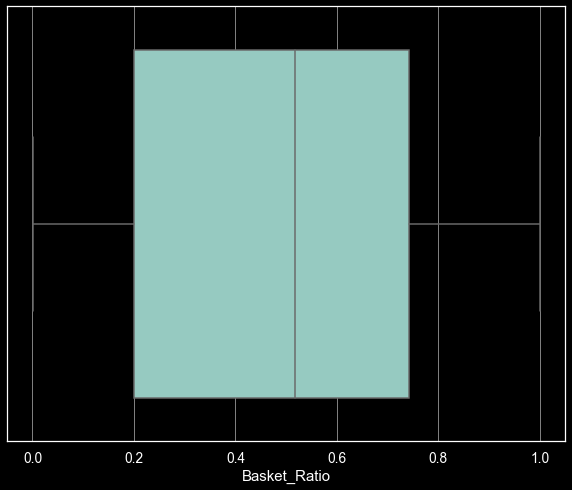

Column: Basket_Ratio
--------------------
Mean => 0.484
25% values are less than => 0.2
75% values are less than => 0.742
Inter-Quartile-Range => 0.542


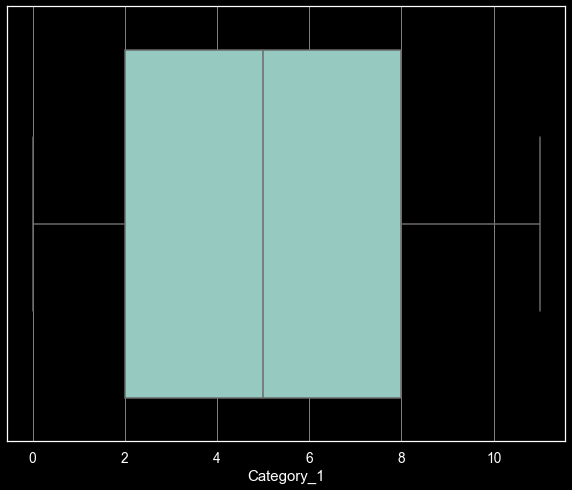

Column: Category_1
--------------------
Mean => 5.156
25% values are less than => 2.0
75% values are less than => 8.0
Inter-Quartile-Range => 6.0


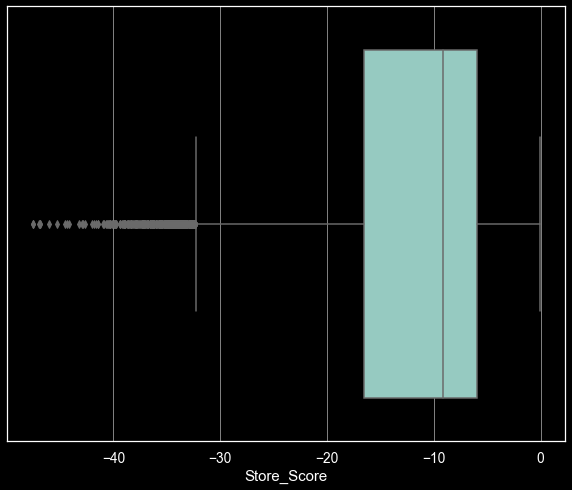

Column: Store_Score
--------------------
Mean => -12.198
25% values are less than => -16.496
75% values are less than => -5.944
Inter-Quartile-Range => 10.552


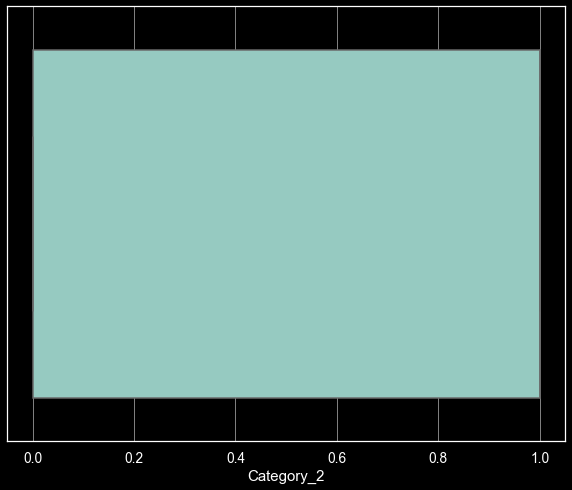

Column: Category_2
--------------------
Mean => 0.649
25% values are less than => 0.0
75% values are less than => 1.0
Inter-Quartile-Range => 1.0


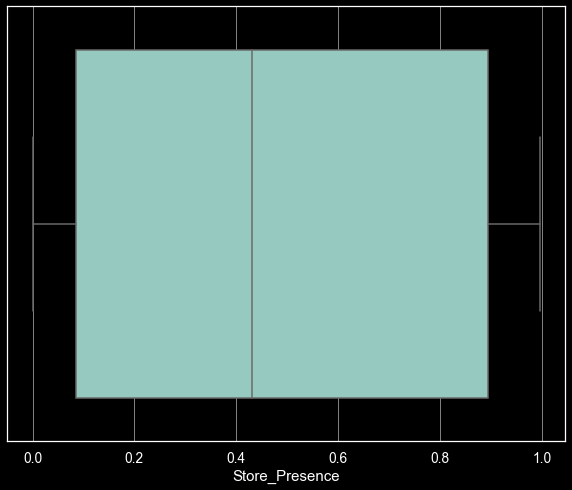

Column: Store_Presence
--------------------
Mean => 0.478
25% values are less than => 0.086
75% values are less than => 0.895
Inter-Quartile-Range => 0.809


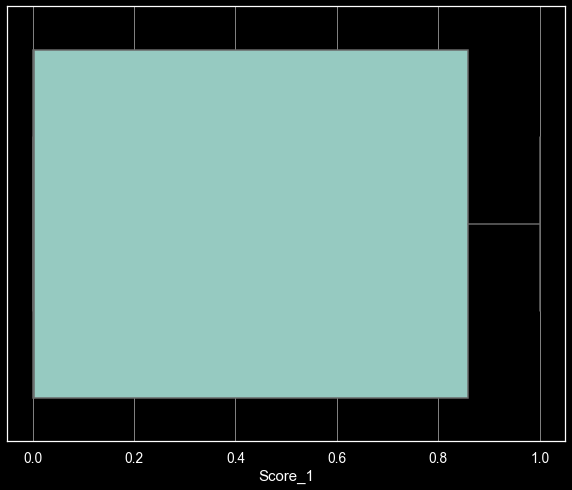

Column: Score_1
--------------------
Mean => 0.322
25% values are less than => 0.0
75% values are less than => 0.859
Inter-Quartile-Range => 0.859


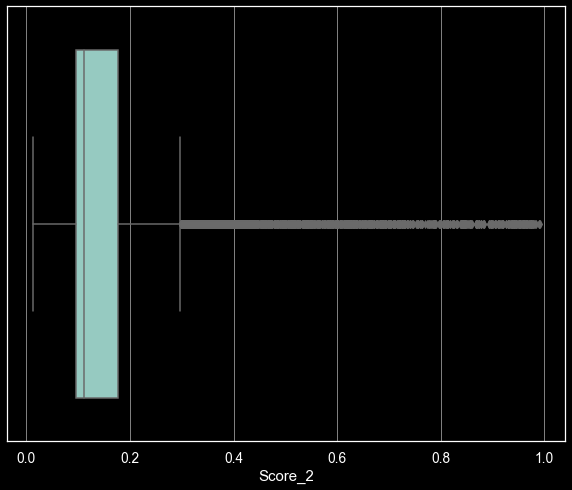

Column: Score_2
--------------------
Mean => 0.165
25% values are less than => 0.095
75% values are less than => 0.176
Inter-Quartile-Range => 0.081


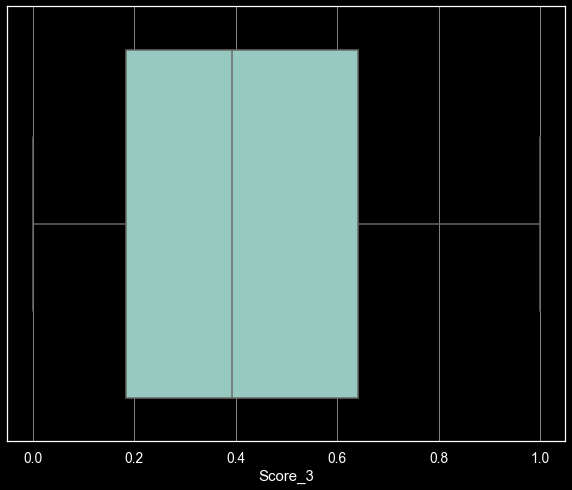

Column: Score_3
--------------------
Mean => 0.421
25% values are less than => 0.185
75% values are less than => 0.64
Inter-Quartile-Range => 0.455


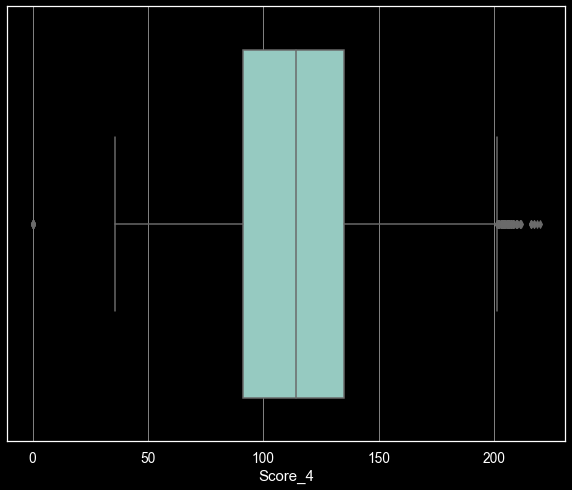

Column: Score_4
--------------------
Mean => 115.306
25% values are less than => 90.974
75% values are less than => 134.997
Inter-Quartile-Range => 44.023


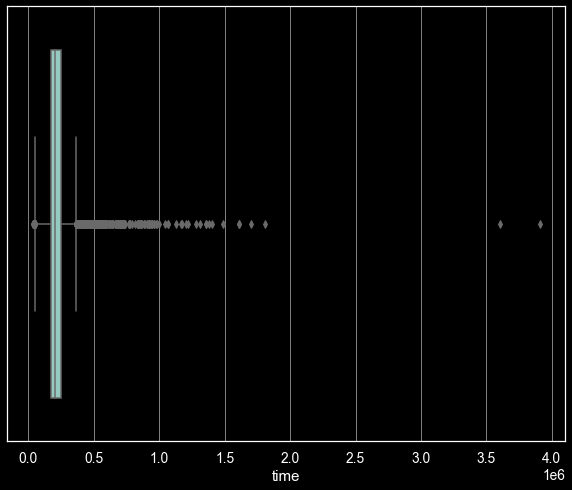

Column: time
--------------------
Mean => 218010.143
25% values are less than => 169620.25
75% values are less than => 247156.25
Inter-Quartile-Range => 77536.0


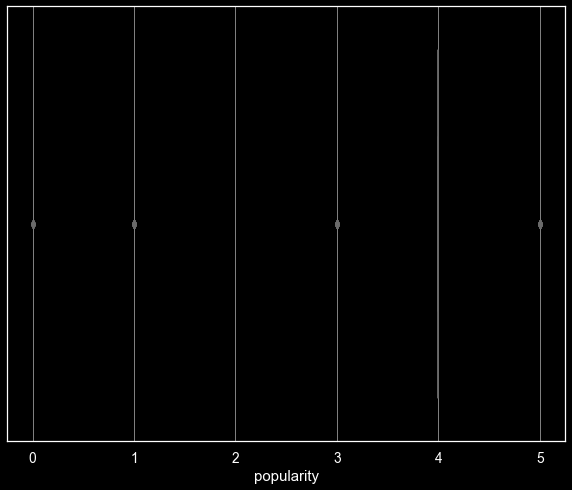

Column: popularity
--------------------
Mean => 3.85
25% values are less than => 4.0
75% values are less than => 4.0
Inter-Quartile-Range => 0.0


In [52]:
print("*" * 40)
print("From BOX-PLOT we can infer the following")
print("*" * 40)

for col in train_df.columns.to_list():
    _ = sns.boxplot(data=train_df, x=col)
    plt.show()
    q1 = train_df[col].quantile(0.25)
    q2 = train_df[col].quantile(0.75)
    iqr = q2 - q1
    print(("=" * 40))
    print(f"Column: {col}")
    print(("-" * 20))
    print(f"Mean => {round(train_df[col].mean(), 3)}")
    print(f"25% values are less than => {round(q1, 3)}")
    print(f"75% values are less than => {round(q2, 3)}")
    print(f"Inter-Quartile-Range => {round(iqr, 3)}")
    print(("=" * 40))

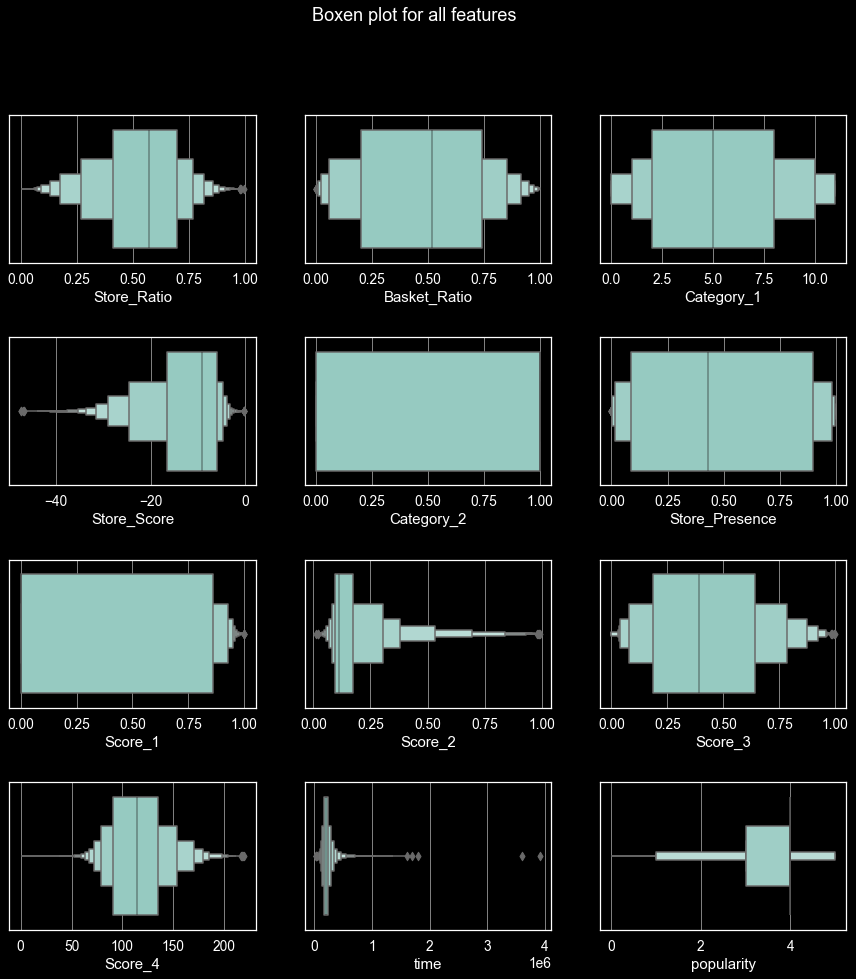

In [53]:
plot_all_feats(df=train_df, typ="boxen", title="Boxen plot for all features")

*Obvservation*
- For our skewed features `Score_2` & `Store_Presence` we can see that the tails doesn't fall off as sharply. 
- It falls off rather smoothly, unlike incase of `time` where the tail is rather sharp

Same can be seen with the violin plots too

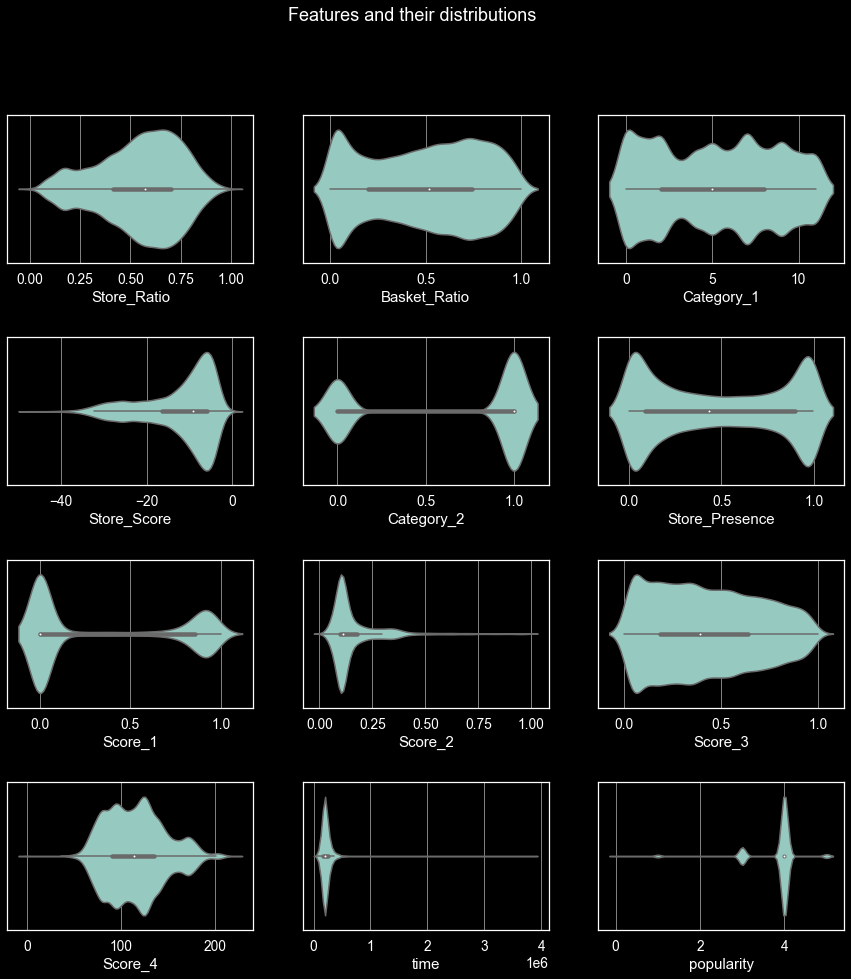

In [54]:
plot_all_feats(train_df, "violin")

### Bivariate Analysis

#### Pair plot

In [55]:
# _ = sns.pairplot(train_df.iloc[:1000, :], palette='bright', hue='popularity')

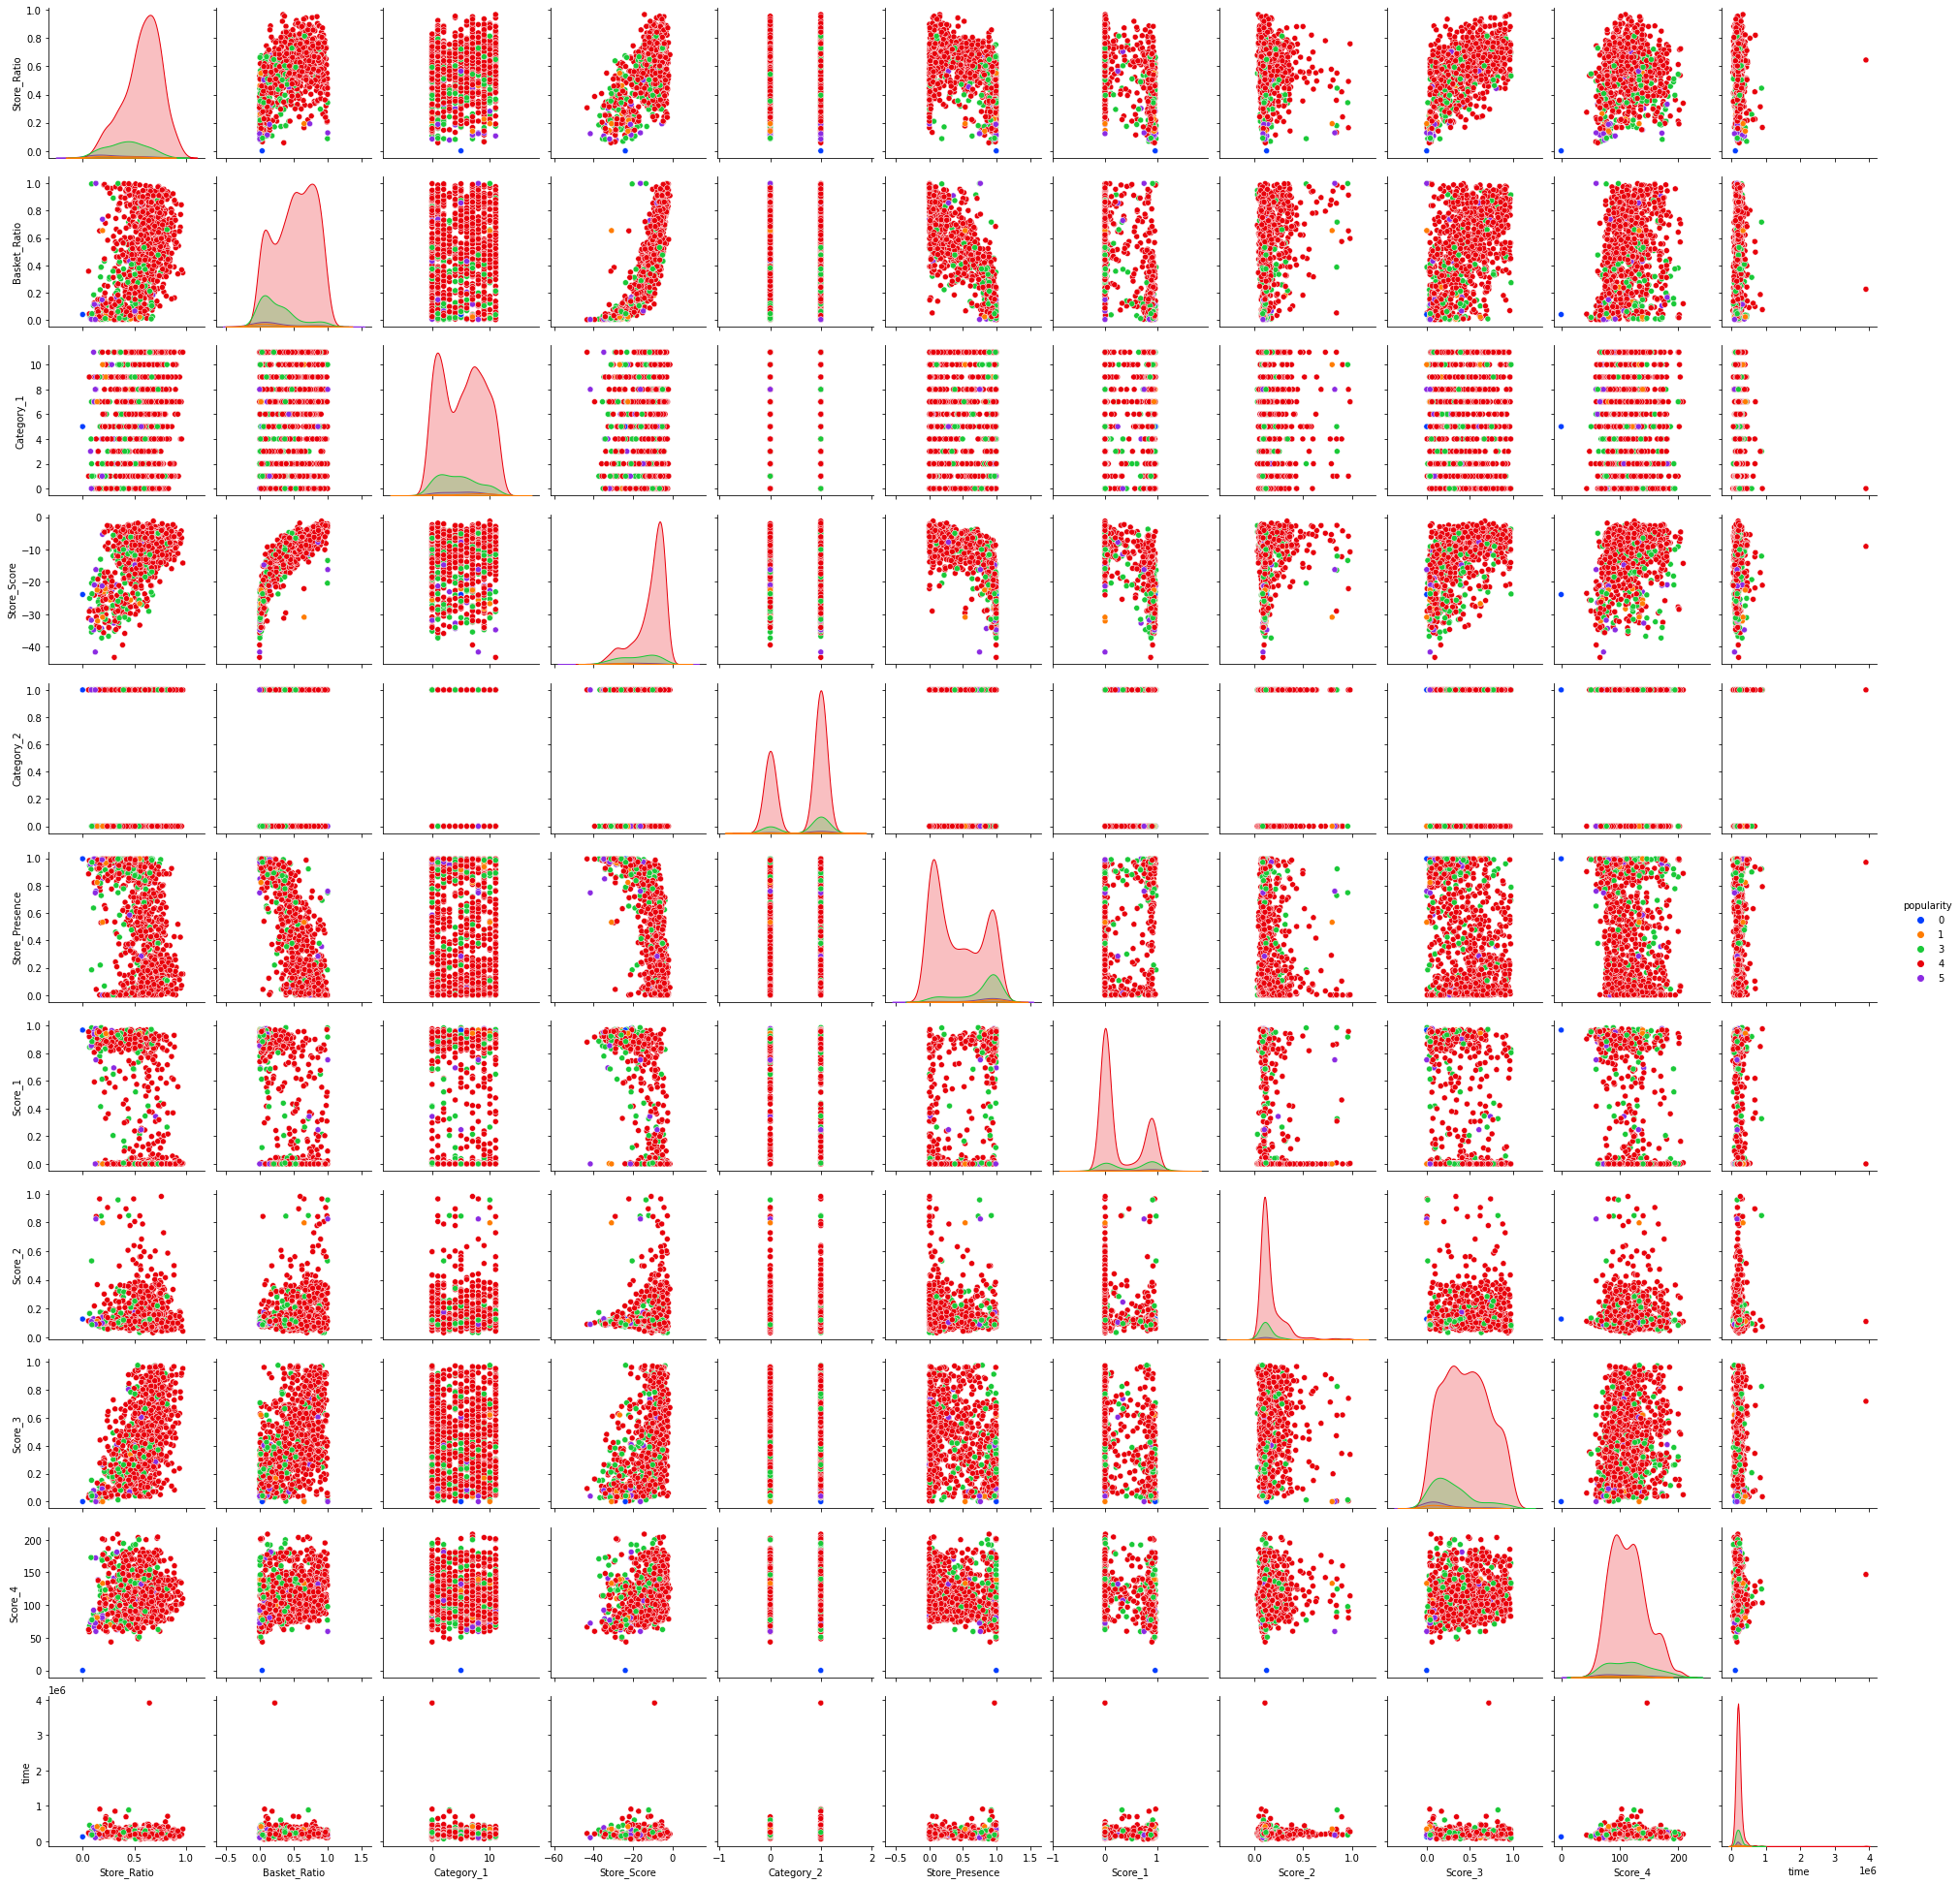

In [56]:
display(Image("pairplot.png"))

*Obvservation*
- `Store_Score` & `Store_Presence` have negative correlation as we can see that as `Store_Presence` value increases the the `Store_Score` decreases.
- `Store_Score` & `Basket_Ratio` have positive correlatin as we can see that as the value of `Basket_Ratio` increases the `Store_Score` decreases
- There also other correlations

To understand the strength of correlations we will move on to correlation analysis

### Correlation Analysis

In [57]:
corr = train_df.corr()
corr

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time,popularity
Store_Ratio,1.000000,0.465598,0.040335,0.599820,-0.102391,-0.471475,-0.454113,-0.039416,0.620874,0.119472,-0.063763,0.232888
Basket_Ratio,0.465598,1.000000,0.051739,0.826055,-0.114843,-0.821807,-0.612220,0.275749,0.527086,0.253789,0.101478,0.200988
Category_1,0.040335,0.051739,1.000000,0.042988,-0.139914,-0.046474,-0.028973,0.019738,0.036477,0.003057,-0.012886,0.003716
Store_Score,0.599820,0.826055,0.042988,1.000000,-0.085984,-0.723449,-0.726385,0.145093,0.516937,0.263739,0.080659,0.204896
Category_2,-0.102391,-0.114843,-0.139914,-0.085984,1.000000,0.104456,0.020086,-0.036357,-0.043944,-0.046058,-0.009798,-0.034565
Store_Presence,-0.471475,-0.821807,-0.046474,-0.723449,0.104456,1.000000,0.571346,-0.190961,-0.431723,-0.222663,-0.072484,-0.195113
Score_1,-0.454113,-0.612220,-0.028973,-0.726385,0.020086,0.571346,1.000000,-0.104020,-0.474795,-0.201852,-0.113319,-0.163667
Score_2,-0.039416,0.275749,0.019738,0.145093,-0.036357,-0.190961,-0.104020,1.000000,0.033445,0.019435,-0.002480,0.001737
Score_3,0.620874,0.527086,0.036477,0.516937,-0.043944,-0.431723,-0.474795,0.033445,1.000000,0.181573,0.009258,0.176765
Score_4,0.119472,0.253789,0.003057,0.263739,-0.046058,-0.222663,-0.201852,0.019435,0.181573,1.000000,0.026966,0.043677


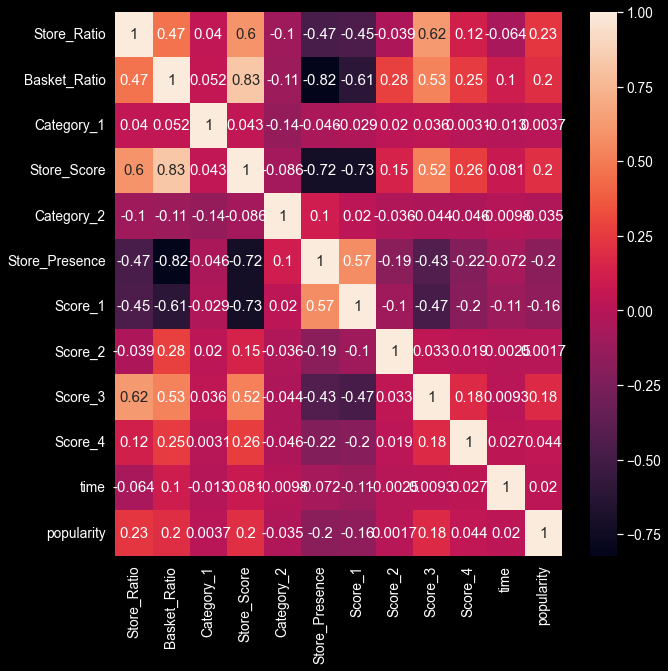

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr, annot=True)

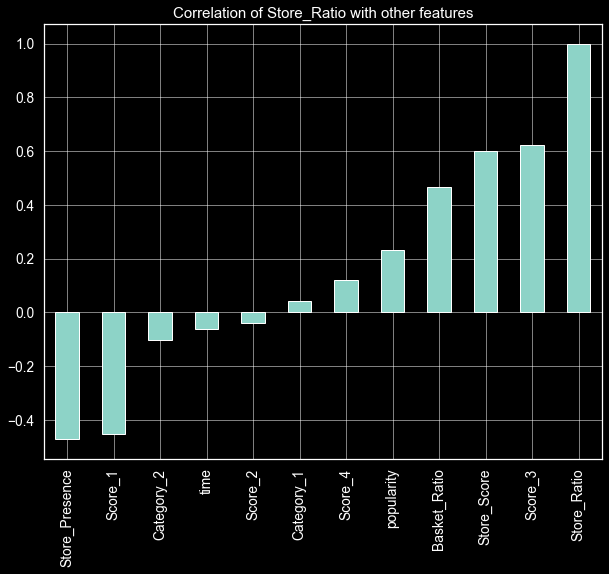

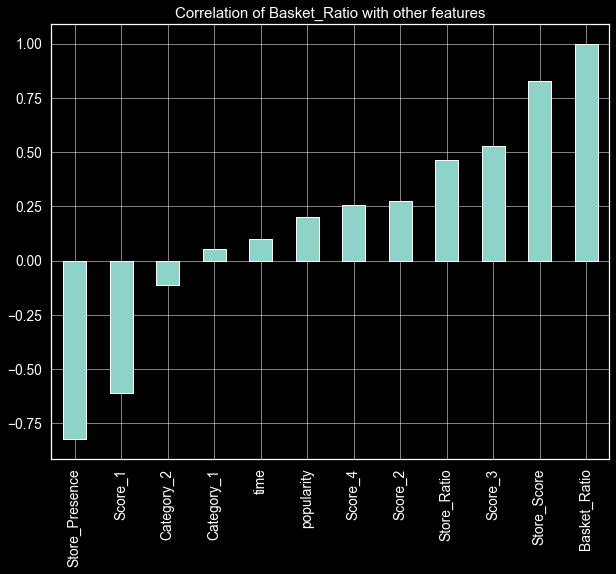

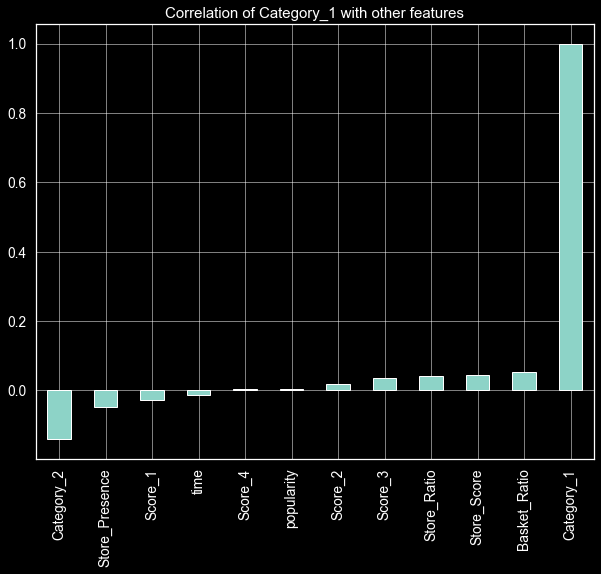

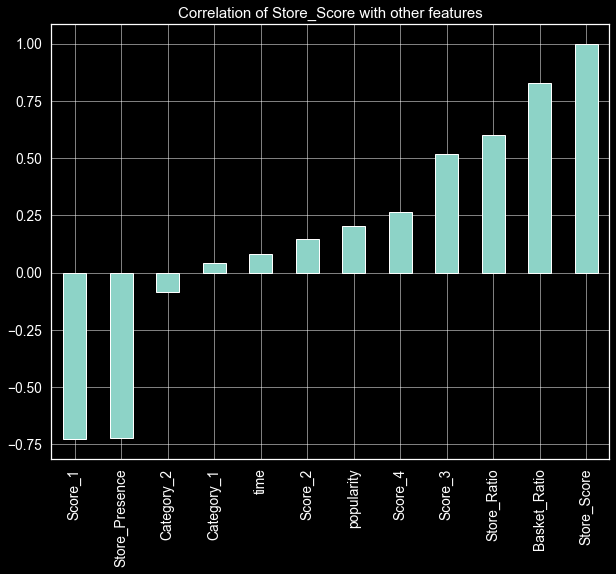

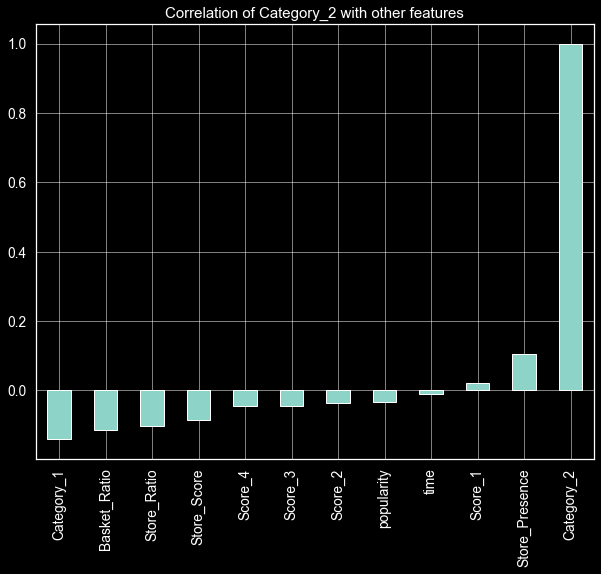

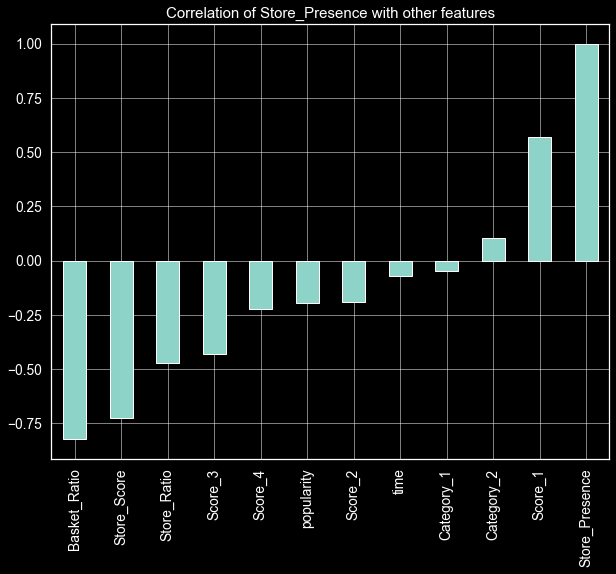

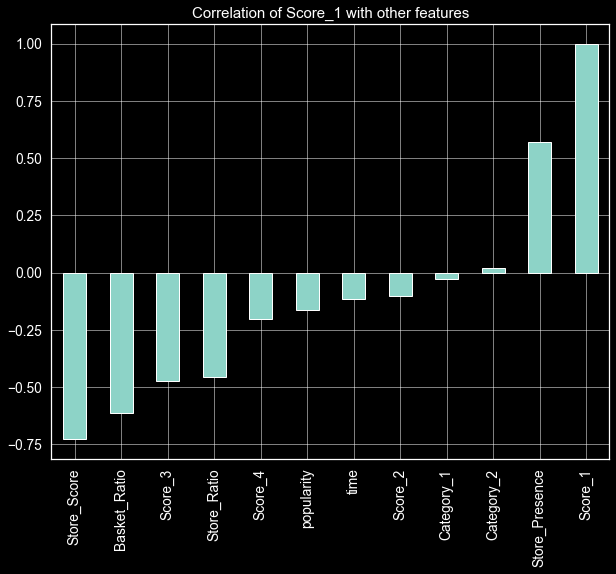

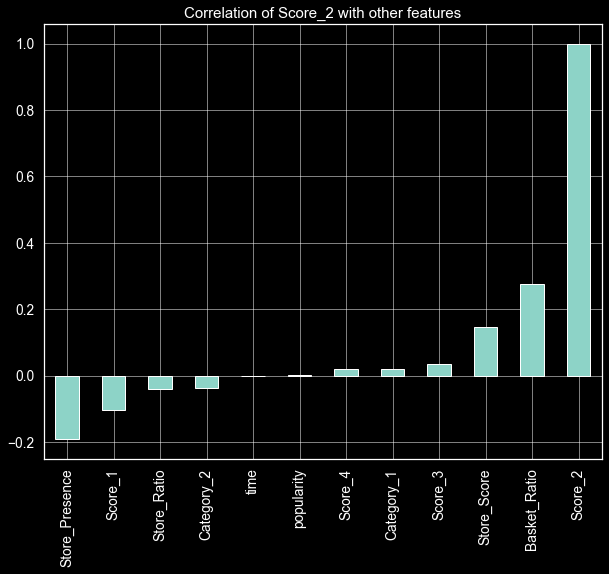

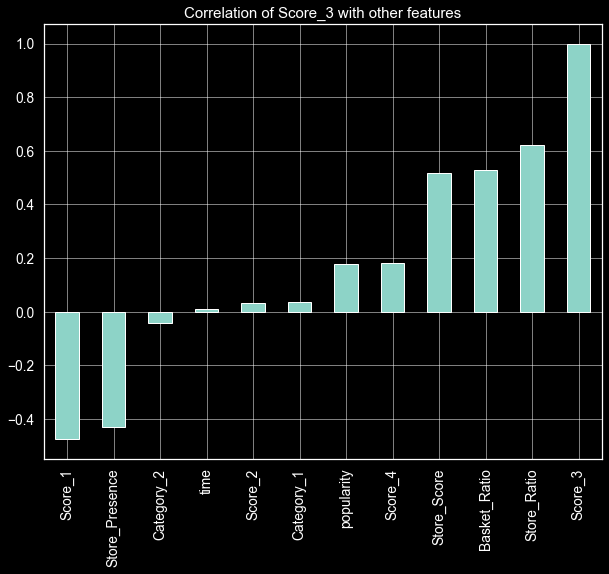

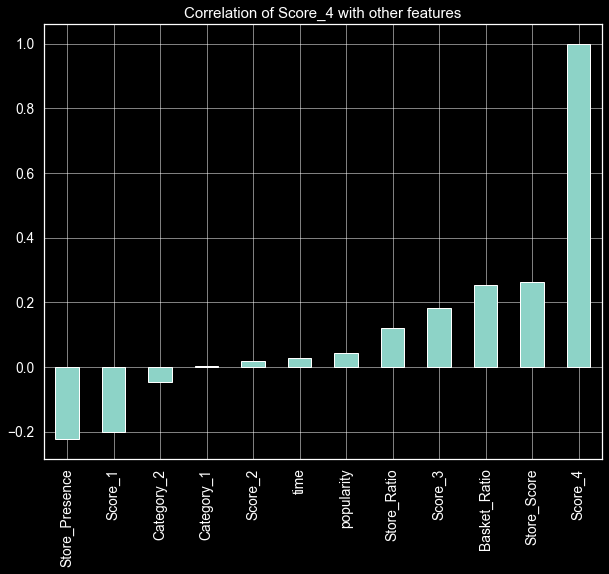

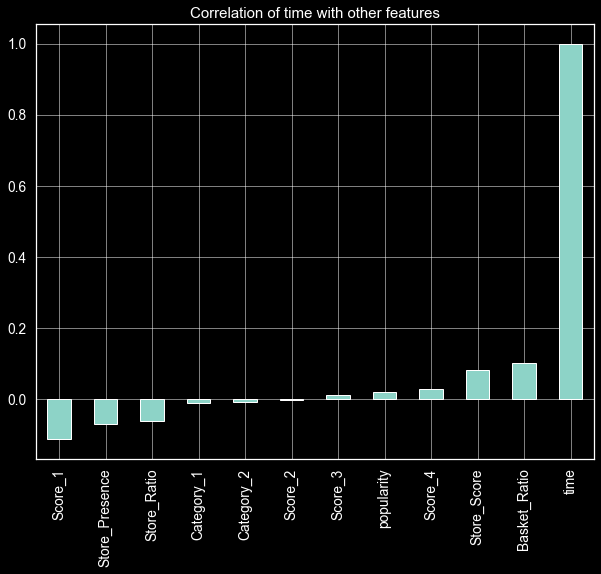

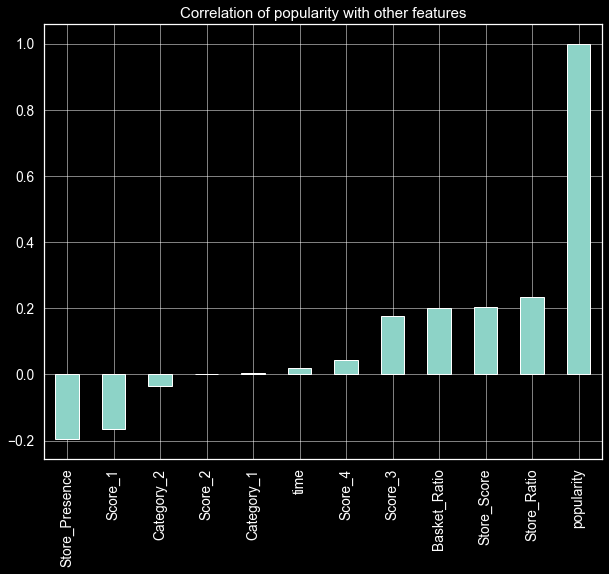

In [59]:
for col in corr.columns:
    corr[col].sort_values().plot.bar()
    plt.title(f"Correlation of {col} with other features")
    plt.show()

*Obvservation*

- `Store_Ratio` is strongly correlated with `Basket_Ratio`, `Store_Score`, `Score_3` , `Store_Presence`, `Score1`, `Score_3`
- `Basket_Ratio` is correlatd to `Store_Score`, `Store_Presence`, `Score_1`, `Score_3`.
- `Category_1` is correlated with `Category_2`
- `Score_Presence` is correlated with `Score_1`, `Score_2`, `Score_3`, `popularity`
- `Score_1` is correlated with `Score_3`, `Score_4`, `time`, `popularity`

## Feature Engineering

Now that we have seen that a lot of features are correlated to one another, let's see if we can describe our data still by reducing the features

### `time` feature

Before that we have a feature called `time`. Let's see what it is and if we can convert it into something else

In [60]:
time_feat = train_df['time']
time_feat.head()

0    189125
1    186513
2    172143
3    184000
4    186507
Name: time, dtype: int64

This feature contains timestamps. Let's convert them into something more meaningful. Let's see the first one

In [61]:
x = datetime.datetime.fromtimestamp(time_feat[0])
str(x)

'1970-01-03 10:02:05'

This maps onto the date: 3rd of jan, 1970 at 10:02 am. Now let's look into the whole column

In [62]:
times = []
for t in time_feat:
    current = str(datetime.datetime.fromtimestamp(t))
    times.append(current[:current.index(" ")])

In [63]:
np.unique(times)

array(['1970-01-01', '1970-01-02', '1970-01-03', '1970-01-04',
       '1970-01-05', '1970-01-06', '1970-01-07', '1970-01-08',
       '1970-01-09', '1970-01-10', '1970-01-11', '1970-01-12',
       '1970-01-13', '1970-01-14', '1970-01-15', '1970-01-16',
       '1970-01-17', '1970-01-18', '1970-01-19', '1970-01-20',
       '1970-01-22', '1970-02-11', '1970-02-15'], dtype='<U10')

*Obvservation*
- We can see that we have time data for the months of january and february for the year 1970. 

In [64]:
# making a copy of train_df 
train_df_copy = train_df.copy(deep=True)

In [65]:
# Creating new columns for week, day, hour
train_df_copy['weekday'] = train_df_copy.time.map(lambda x : datetime.datetime.fromtimestamp(x).weekday())
train_df_copy['day'] = train_df_copy.time.map(lambda x : datetime.datetime.fromtimestamp(x).day)
train_df_copy['hour'] = train_df_copy.time.map(lambda x : datetime.datetime.fromtimestamp(x).hour)

In [66]:
train_df_copy.head()

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time,popularity,weekday,day,hour
0,0.407,0.00380,2,-35.865,1,0.9920,0.944,0.0988,0.1100,113.911,189125,4,5,3,10
1,0.234,0.10500,0,-19.884,1,0.9440,0.900,0.1290,0.0382,76.332,186513,4,5,3,9
2,0.668,0.72600,9,-7.512,1,0.0387,0.000,0.1340,0.4530,124.075,172143,4,5,3,5
3,0.184,0.00561,4,-34.357,1,0.8490,0.931,0.1110,0.0641,79.037,184000,5,5,3,8
4,0.231,0.13100,6,-22.842,1,0.9370,0.000,0.1090,0.0677,109.560,186507,3,5,3,9


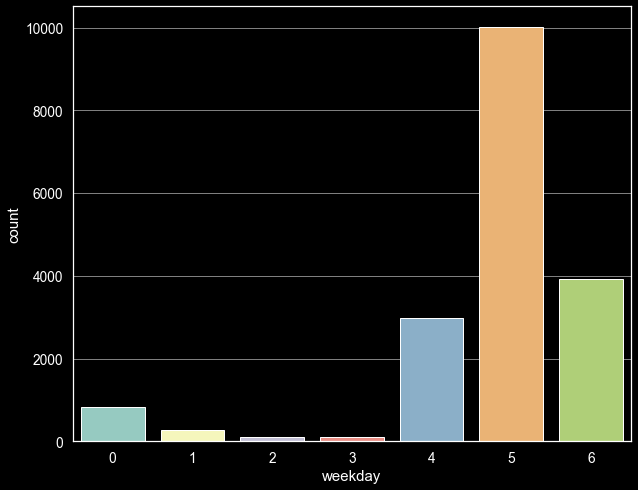

In [67]:
_ = sns.countplot(data=train_df_copy, x='weekday')

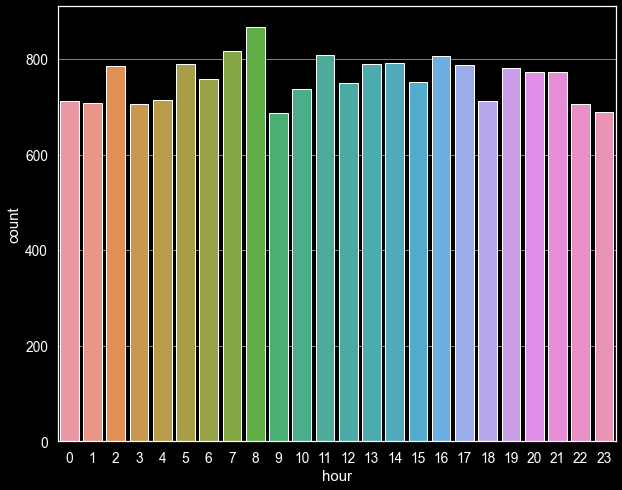

In [68]:
_ = sns.countplot(data=train_df_copy, x='hour')

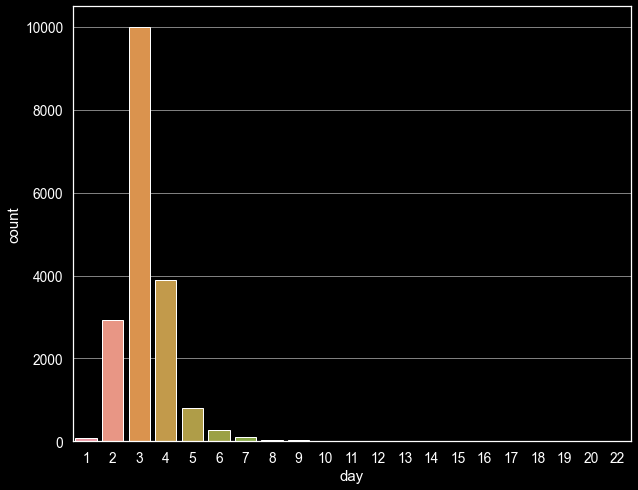

In [69]:
_ = sns.countplot(data=train_df_copy, x='day')

*Obvservation*
- 3rd January, 1970 seems to be a special day
- A lot of merchandises were purchased on this day. It was a saturday
- What were the merchandies bought for I wonder ?

In [70]:
corr_train_df_copy = train_df_copy.corr()

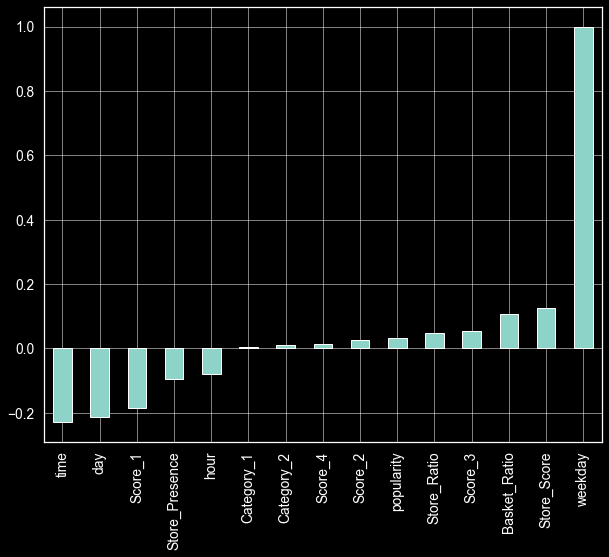

In [71]:
_ = corr_train_df_copy['weekday'].sort_values().plot.bar()

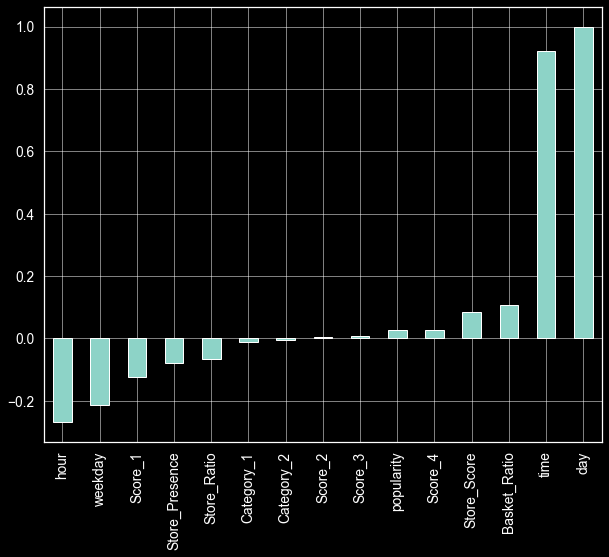

In [72]:
_ = corr_train_df_copy['day'].sort_values().plot.bar()

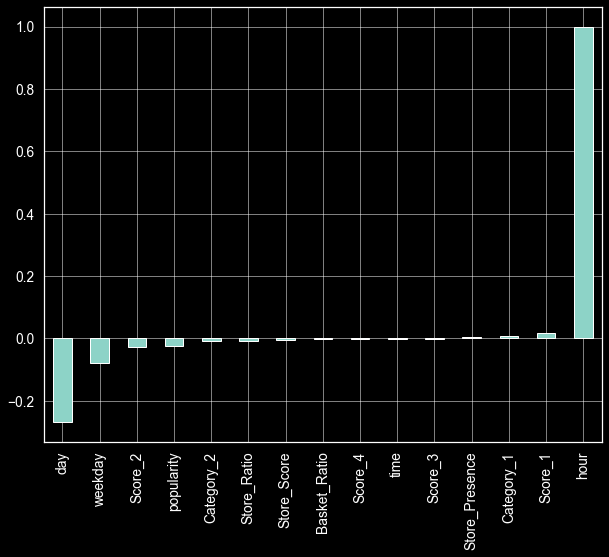

In [73]:
_ = corr_train_df_copy['hour'].sort_values().plot.bar()

*Obvservation*
- All our three new columns `day`, `weekday` & `hour` have little to no correlation with other features
- I am going to drop the time feature from the dataset now that we have 3 new features derived from time
- The new features give a better idea about our data. We see that 3rd jan, 1970 seems to be an important day with most values pertaining to this day

In [74]:
train_df_copy.drop('time', axis=1, inplace=True)

In [75]:
train_df_copy.to_csv("./Feature_files/All_features_with_basic_time_feats.csv", index=False)

## Feature Selection

In [76]:
scaler = MinMaxScaler(feature_range=(1, 10))

In [77]:
X = train_df_copy.drop('popularity', axis=1)
y = train_df_copy['popularity']

In [78]:
X.shape, y.shape

((18208, 13), (18208,))

In [79]:
X_scaled = scaler.fit_transform(X)

In [80]:
FEATURE_COLS = train_df_copy.columns.to_list()
FEATURE_COLS.remove('popularity')

In [81]:
X_scaled_df = pd.DataFrame(X_scaled, columns=FEATURE_COLS)
X_scaled_df.head()

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,weekday,day,hour
0,4.670341,1.032263,2.636364,3.219066,10.0,9.963855,9.496,1.798795,1.990991,5.666337,8.5,1.857143,4.913043
1,3.110220,1.943260,1.000000,6.247237,10.0,9.530120,9.100,2.076397,1.344144,4.126922,8.5,1.857143,4.521739
2,7.024048,7.533467,8.363636,8.591553,10.0,1.349699,1.000,2.122357,5.081081,6.082703,8.5,1.857143,2.956522
3,2.659319,1.048556,4.272727,3.504811,10.0,8.671687,9.379,1.910939,1.577477,4.237732,8.5,1.857143,4.130435
4,3.083166,2.177310,5.909091,5.686738,10.0,9.466867,1.000,1.892554,1.609910,5.488100,8.5,1.857143,4.521739


### Variance Thresholding

In [82]:
vt = VarianceThreshold(threshold=1)

In [83]:
X_scaled_vt = vt.fit_transform(X_scaled_df)

In [84]:
vt.get_feature_names_out()

array(['Store_Ratio', 'Basket_Ratio', 'Category_1', 'Store_Score',
       'Category_2', 'Store_Presence', 'Score_1', 'Score_2', 'Score_3',
       'Score_4', 'weekday', 'hour'], dtype=object)

In [85]:
X_scaled_vt_df = pd.concat([train_df_copy[vt.get_feature_names_out()], train_df_copy.popularity], axis=1)

In [86]:
X_scaled_vt_df.head()

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,weekday,hour,popularity
0,0.407,0.00380,2,-35.865,1,0.9920,0.944,0.0988,0.1100,113.911,5,10,4
1,0.234,0.10500,0,-19.884,1,0.9440,0.900,0.1290,0.0382,76.332,5,9,4
2,0.668,0.72600,9,-7.512,1,0.0387,0.000,0.1340,0.4530,124.075,5,5,4
3,0.184,0.00561,4,-34.357,1,0.8490,0.931,0.1110,0.0641,79.037,5,8,5
4,0.231,0.13100,6,-22.842,1,0.9370,0.000,0.1090,0.0677,109.560,5,9,3


In [87]:
X_scaled_vt_df.to_csv("./Feature_files/Variance_thresholded_features.csv", index=False)

### Recursive feature elimination

In [88]:
dt = DecisionTreeClassifier()
rfes = []
for i in tqdm(range(1, 14)):
    rfe = RFE(estimator=dt, n_features_to_select=i)
    rfe.fit(X, y)
    rfes.append(rfe)

  0%|          | 0/13 [00:00<?, ?it/s]

In [89]:
rfes

[RFE(estimator=DecisionTreeClassifier(), n_features_to_select=1),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=2),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=3),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=4),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=6),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=7),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=8),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=9),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=11),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=12),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=13)]

In [90]:
for i, r in tqdm(enumerate(rfes, 1)):
    if i >= 3 and i <= 11:
        temp_df = pd.concat([train_df_copy[r.get_feature_names_out()], train_df_copy.popularity], axis=1)
        temp_df.to_csv(f"./Feature_files/RFE-{i}-features.csv", index=False)

0it [00:00, ?it/s]

### Anova Test

In [91]:
anovas = []
for i in tqdm(range(1, 14)):
    anova_filter = SelectKBest(score_func=f_classif, k=i)
    anova_filter.fit(X, y)
    anovas.append(anova_filter)

  0%|          | 0/13 [00:00<?, ?it/s]

In [92]:
for i, a in tqdm(enumerate(anovas, 1)):
    if i >= 3 and i <= 11:
        temp_df = pd.concat([train_df_copy[a.get_feature_names_out()], train_df.popularity], axis=1)
        temp_df.to_csv(f"./Feature_files/Anova-{i}-features.csv", index=False)

0it [00:00, ?it/s]

## Modelling

The original competetion had `log-loss` as the metric to be optimized, but here I would also look at other metrics. The labels are highly imbalanced, so simple metrics like `accuracy` won't be a goo measure of the performance.

We will use class weights, to get a more balanced picture

### Preprocessing

In [93]:
train_df = pd.read_csv("./Feature_files/All_features_with_basic_time_feats.csv").sample(frac=1).reset_index(drop=True)

In [94]:
train_df.head()

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,popularity,weekday,day,hour
0,0.849,0.489,0,-7.433,1,0.68500,0.000022,0.1080,0.344,113.972,4,5,3,11
1,0.843,0.845,0,-2.344,1,0.35000,0.001680,0.0527,0.898,126.989,4,5,3,16
2,0.561,0.782,3,-7.444,1,0.02200,0.000000,0.1090,0.704,127.148,4,5,3,0
3,0.631,0.792,0,-4.364,0,0.23000,0.000317,0.0756,0.462,82.901,4,6,4,2
4,0.374,0.847,2,-4.953,1,0.00237,0.000309,0.3450,0.485,160.099,4,5,3,18


In [95]:
X = train_df.drop("popularity", axis=1)
y = train_df.popularity

### Splitting the dataset

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [97]:
# Scaling X_train and X_test 
scaler = MinMaxScaler(feature_range=(1, 10))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [152]:
def get_metrics(y_true, y_pred):
    print(f"Balanced Accuracy: {round(metrics.balanced_accuracy_score(y_true, y_pred), 3)}")
    recall_macro, specificity, _ = sensitivity_specificity_support(y_true, y_pred, average='macro')
    print(f"Macro Recall (info about positives in the data): {round(recall_macro, 3)}")
    print(f"Specificity (info about negatives in the data): {round(specificity, 3)}")
    print(f"Macro f1-score: {round(metrics.f1_score(y_true, y_pred, average='macro'), 3)}")
    print(metrics.classification_report(y_true, y_pred))
    cf = metrics.confusion_matrix(y_test, y_pred)
    _ = sns.heatmap(
        cf, 
        annot=True, 
        fmt="d", 
        cmap='cool', 
        xticklabels=np.unique(y_test), 
        yticklabels=np.unique(y_test)
    )

### Logistic Regression

Since our dataset is imbalanced, I will be using class weights such that the most amount of weightage is given to the minority class and lowest to the majority class.

In [100]:
# With balanced weights
lr_balanced = LogisticRegression(
    multi_class='multinomial', 
    class_weight='balanced', 
    solver='newton-cg',
    verbose=3
)

# Vanilla LR
lr = LogisticRegression(
    multi_class='multinomial', 
    solver='newton-cg',
    verbose=3
)

In [101]:
%%time
lr.fit(X_train_scaled, y_train.values)
lr_balanced.fit(X_train_scaled, y_train.values)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 8.13 s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg', verbose=3)

In [106]:
y_pred = lr.predict(X_test_scaled)
y_pred_bal = lr_balanced.predict(X_test_scaled)

Balanced Accuracy: 0.409
Macro Recall (info about positives in the data): 0.409
Specificity (info about negatives in the data): 0.81
Macro f1-score: 0.402
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00        48
           3       0.39      0.05      0.09       319
           4       0.85      0.99      0.92      2301
           5       0.00      0.00      0.00        63

    accuracy                           0.84      2732
   macro avg       0.45      0.41      0.40      2732
weighted avg       0.76      0.84      0.78      2732



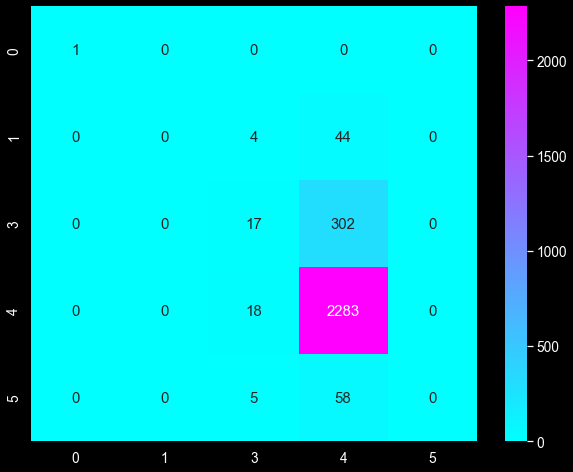

In [153]:
get_metrics(y_test, y_pred)

Balanced Accuracy: 0.527
Macro Recall (info about positives in the data): 0.527
Specificity (info about negatives in the data): 0.889
Macro f1-score: 0.382
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.04      0.31      0.07        48
           3       0.21      0.27      0.24       319
           4       0.95      0.68      0.80      2301
           5       0.08      0.37      0.14        63

    accuracy                           0.62      2732
   macro avg       0.36      0.53      0.38      2732
weighted avg       0.83      0.62      0.70      2732



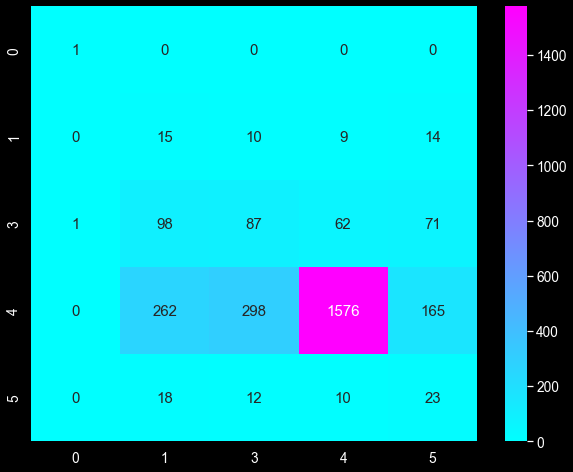

In [154]:
get_metrics(y_test, y_pred_bal)

In [130]:
coef_df = pd.DataFrame(
    {
        "features": X_train.columns,
        "importances_0": np.exp(lr.coef_[0]),
        "importances_1": np.exp(lr.coef_[1]),
        "importances_3": np.exp(lr.coef_[2]),
        "importances_4": np.exp(lr.coef_[3]),
        "importances_5": np.exp(lr.coef_[4])
    }
).round(2)

In [131]:
coef_df

,features,importances_0,importances_1,importances_3,importances_4,importances_5
0,Store_Ratio,0.40,1.11,1.19,1.74,1.09
1,Basket_Ratio,0.85,1.04,0.98,1.18,0.98
2,Category_1,0.92,1.04,1.02,1.02,1.01
3,Store_Score,1.28,0.96,1.01,0.91,0.88
4,Category_2,0.99,1.02,1.00,1.00,0.98
5,Store_Presence,0.94,1.03,1.08,0.97,1.00
6,Score_1,1.07,0.99,0.99,0.98,0.97
7,Score_2,1.08,1.06,0.97,0.90,1.00
8,Score_3,0.68,1.03,1.14,1.16,1.08
9,Score_4,0.12,1.63,1.88,1.56,1.74


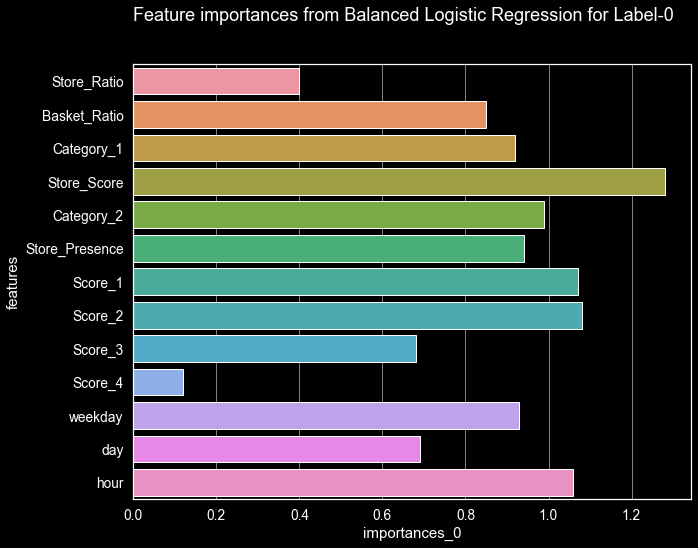

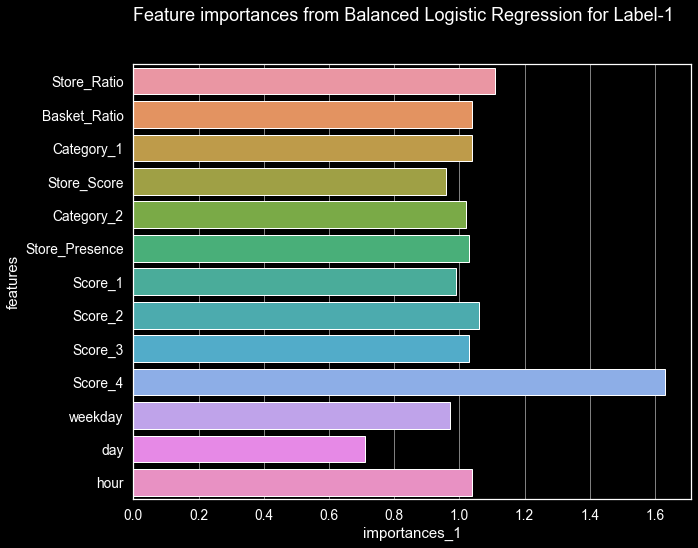

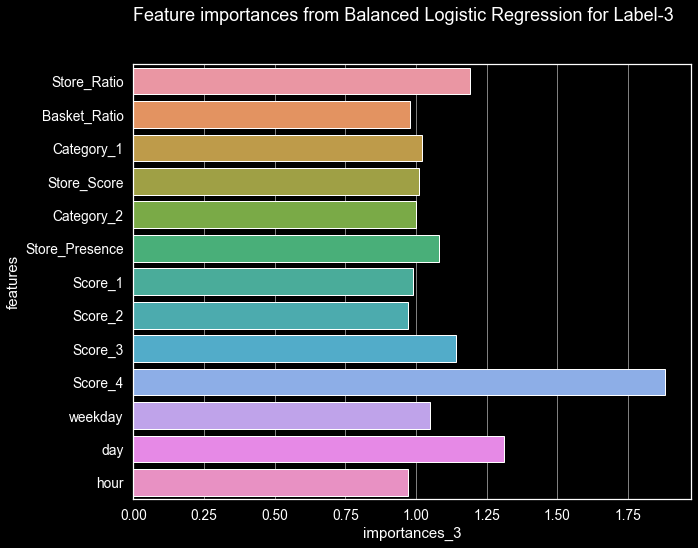

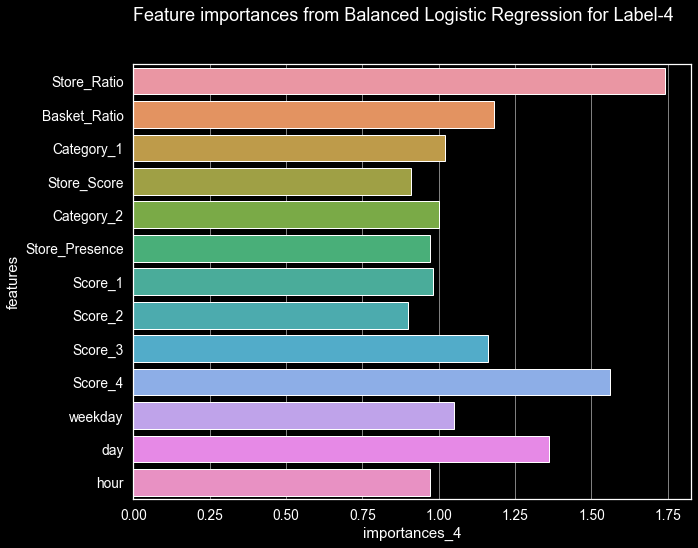

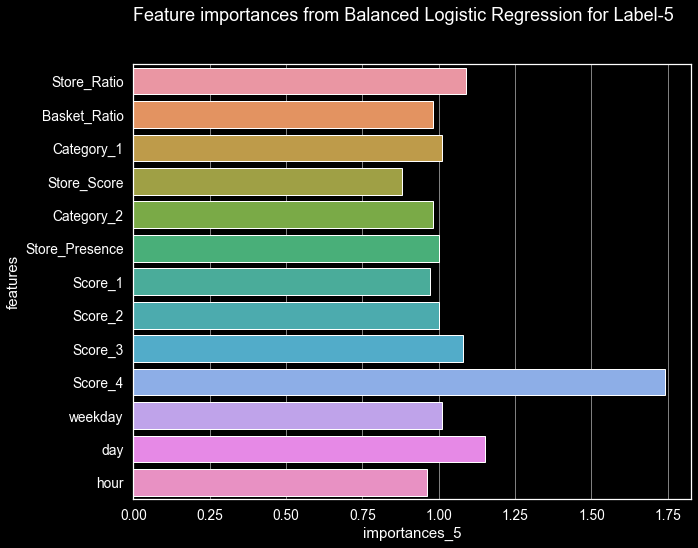

In [136]:
for col in coef_df.columns.to_list()[1:]:
    _ = sns.barplot(data=coef_df, y='features', x=col)
    plt.suptitle(f"Feature importances from Balanced Logistic Regression for Label-{col.split('_')[-1]}")
    plt.show()

### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(class_weight='balanced')

In [ ]:
cv_results = cross_validate(
    X=X_train,
    y=y_train,
    estimator=dt, 
    cv=10,
    scoring="f1_weighted",
    return_estimator=True
)

In [ ]:
cv_results

In [ ]:
est = cv_results['estimator'][np.where(cv_results['test_score'] == cv_results['test_score'].max())[0][0]]

In [ ]:
y_pred = est.predict(X_test)

In [ ]:
print(metrics.classification_report(y_true=y_test, y_pred=y_pred))